## PubMed API Python script

- This is the python script use for get huge PubMed data from NCBI API.  
Document is here. https://www.ncbi.nlm.nih.gov/books/NBK25501/
- You have to read below term before use this script.  
https://www.nlm.nih.gov/databases/download/terms_and_conditions.html

### What's Output?

outputimage

### Import Library

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import requests
import urllib.parse
import uuid
import xml.etree.ElementTree as ET
from collections import OrderedDict
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook as tqdm

plotly.offline.init_notebook_mode(connected=False)


### Parameters

In [95]:
# const
BASEURL_INFO = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/einfo.fcgi'
BASEURL_SRCH = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi'
BASEURL_FTCH = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi'

# parameters
SOURCE_DB    = 'pubmed'
TERM         = 'cancer'
DATE_TYPE    = 'pdat'       # Type of date used to limit a search. The allowed values vary between Entrez databases, but common values are 'mdat' (modification date), 'pdat' (publication date) and 'edat' (Entrez date). Generally an Entrez database will have only two allowed values for datetype.
MIN_DATE     = '2018/01/01' # yyyy/mm/dd
MAX_DATE     = '2019/12/31' # yyyy/mm/dd
SEP          = '|'
BATCH_NUM    = 1000

# seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### functions

In [234]:
'''
make query function

base_url: base_url
params: parameter dictionary
        ex) {key1: value1, key2: value2}
'''
def mkquery(base_url, params):
    base_url += '?'
    for key, value in zip(params.keys(), params.values()):
        base_url += '{key}={value}&'.format(key=key, value=value)
    url = base_url[0:len(base_url) - 1]
    print('request url is: ' + url)
    return url

'''
getXmlFromURL
(mkquery wrapper)

base_url: base_url
params: parameter dictionary
        ex) {key1: value1, key2: value2}
'''
def getXmlFromURL(base_url, params):
    response = requests.get(mkquery(base_url, params))
    return ET.fromstring(response.text)

'''
getTextFromNode

root: Xml root node
path: XPath
fill: fill na string
mode: 0 = text, 1 = attribute
attrib: attribute name
'''
def getTextFromNode(root, path, fill='', mode=0, attrib='attribute'):
    if (root.find(path) == None):
        return fill
    else:
        if mode == 0:
            return root.find(path).text
        if mode == 1:
            return root.find(path).get(attrib)
    

# example
rootXml = getXmlFromURL(BASEURL_INFO, {'db': SOURCE_DB})

request url is: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/einfo.fcgi?db=pubmed


## Statistic

In [235]:
# Info API
rootXml = getXmlFromURL(BASEURL_INFO, {'db': SOURCE_DB})
print(rootXml.find('DbInfo').find('Count').text)
print(rootXml.find('DbInfo').find('LastUpdate').text)

request url is: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/einfo.fcgi?db=pubmed
30214909
2019/10/13 20:30


### Get Total Count

In [236]:
# get xml
rootXml = getXmlFromURL(BASEURL_SRCH, {
    'db': SOURCE_DB,
    'term': TERM,
    'usehistory': 'y',
    'datetype': DATE_TYPE,
    'mindate': MIN_DATE,
    'maxdate': MAX_DATE})

request url is: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=cancer&usehistory=y&datetype=pdat&mindate=2018/01/01&maxdate=2019/12/31


In [237]:
# get querykey and webenv
Count = rootXml.find('Count').text
QueryKey = rootXml.find('QueryKey').text
WebEnv = urllib.parse.quote(rootXml.find('WebEnv').text)

print('total Count: ', Count)
print('QueryKey   : ', QueryKey)
print('WebEnv     : ', WebEnv)

total Count:  338233
QueryKey   :  1
WebEnv     :  NCID_1_139733426_130.14.18.48_9001_1571037702_959831376_0MetA0_S_MegaStore


### Get All details

In [238]:
articleDics = []
authorArticleDics = []
authorAffiliationDics = []

def pushData(rootXml):
    for article in rootXml.iter('PubmedArticle'):
        # get article info
        articleDic = {
            'PMID'                    : getTextFromNode(article, 'MedlineCitation/PMID', ''),
            'JournalTitle'            : getTextFromNode(article, 'MedlineCitation/Article/Journal/Title', ''),
            'Title'                   : getTextFromNode(article, 'MedlineCitation/Article/ArticleTitle', ''),
            'doi'                     : getTextFromNode(article, 'MedlineCitation/Article/ELocationID[@EIdType="doi"]', ''),
            'Abstract'                : getTextFromNode(article, 'MedlineCitation/Article/Abstract/AbstractText', ''),
        #    if you want to get data in flat(denormalized), uncomment below. but it's difficult to use for analytics.
        #    'Authors'                 : SEP.join([author.find('ForeName').text + ' ' +  author.find('LastName').text if author.find('CollectiveName') == None else author.find('CollectiveName').text for author in article.findall('MedlineCitation/Article/AuthorList/')]),
        #    'AuthorIdentifiers'       : SEP.join([getTextFromNode(author, 'Identifier', 'None') for author in article.findall('MedlineCitation/Article/AuthorList/')]),
        #    'AuthorIdentifierSources' : SEP.join([getTextFromNode(author, 'Identifier', 'None', 1, 'Source') for author in article.findall('MedlineCitation/Article/AuthorList/')]),
            'Language'                : getTextFromNode(article, 'MedlineCitation/Article/Language', ''),
            'Year_A'                  : getTextFromNode(article, 'MedlineCitation/Article/ArticleDate/Year', ''),
            'Month_A'                 : getTextFromNode(article, 'MedlineCitation/Article/ArticleDate/Month', ''),
            'Day_A'                   : getTextFromNode(article, 'MedlineCitation/Article/ArticleDate/Day', ''),
            'Year_PM'                 : getTextFromNode(article, 'PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Year', ''),
            'Month_PM'                : getTextFromNode(article, 'PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Month', ''),
            'Day_PM'                  : getTextFromNode(article, 'PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Day', ''),
            'Status'                  : getTextFromNode(article, './PubmedData/PublicationStatus', ''),
            'MeSH'                    : SEP.join([getTextFromNode(mesh, 'DescriptorName') for mesh in article.findall('MedlineCitation/MeshHeadingList/')]),
            'MeSH_UI'                 : SEP.join([getTextFromNode(mesh, 'DescriptorName', '', 1, 'UI') for mesh in article.findall('MedlineCitation/MeshHeadingList/')]),
            'Keyword'                 : SEP.join([keyword.text if keyword.text != None else ''  for keyword in article.findall('MedlineCitation/KeywordList/')])
        }
        articleDics.append(OrderedDict(articleDic))

        if article.find('MedlineCitation/MeshHeadingList/MeshHeading/') != None:
            tmp = article

        # get author info
        for author in article.findall('MedlineCitation/Article/AuthorList/'):

            # publish author ID
            # * It's only random id. not use for identify author. if you want to identify author, you can use identifier.
            authorId = str(uuid.uuid4())

            # author article
            authorArticleDic = {
                'authorId'         : authorId,
                'PMID'             : getTextFromNode(article, 'MedlineCitation/PMID', ''),
                'name'             : getTextFromNode(author, 'ForeName') + ' ' +  getTextFromNode(author,'LastName') if author.find('CollectiveName') == None else author.find('CollectiveName').text,
                'identifier'       : getTextFromNode(author, 'Identifier', '') ,
                'identifierSource' : getTextFromNode(author, 'Identifier', '', 1, 'Source')
            }
            authorArticleDics.append(OrderedDict(authorArticleDic))

            # author affiliation(author: affiliation = 1 : n)
            if author.find('./AffiliationInfo') != None:
                for affiliation in author.findall('./AffiliationInfo'):
                    authorAffiliationDic = {
                        'authorId'          : authorId,
                        'affiliation'       : getTextFromNode(affiliation, 'Affiliation', '') ,
                    }
                    authorAffiliationDics.append(OrderedDict(authorAffiliationDic))


In [239]:
# ceil
iterCount = math.ceil(int(Count) / BATCH_NUM)

# get all data
for i in tqdm(range(iterCount)):
    rootXml = getXmlFromURL(BASEURL_FTCH, {
        'db': SOURCE_DB,
        'query_key': QueryKey,
        'WebEnv': WebEnv,
        'retstart': i * BATCH_NUM,
        'retmax': BATCH_NUM,
        'retmode': 'xml'})
    
    pushData(rootXml)

request url is: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_139733426_130.14.18.48_9001_1571037702_959831376_0MetA0_S_MegaStore&retstart=0&retmax=1000&retmode=xml
request url is: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_139733426_130.14.18.48_9001_1571037702_959831376_0MetA0_S_MegaStore&retstart=1000&retmax=1000&retmode=xml
request url is: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_139733426_130.14.18.48_9001_1571037702_959831376_0MetA0_S_MegaStore&retstart=2000&retmax=1000&retmode=xml
request url is: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_139733426_130.14.18.48_9001_1571037702_959831376_0MetA0_S_MegaStore&retstart=3000&retmax=1000&retmode=xml
request url is: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_139733426_130.14.18.48_9001_1

### Store

In [240]:
# article
df_article = pd.DataFrame(articleDics)
df_article.head(10)

PMID                                       JournalTitle  \
0  31606007                                        Mutagenesis   
1  31606005  European journal of oncology nursing : the off...   
2  31605953  Biomedicine & pharmacotherapy = Biomedecine & ...   
3  31605952  Biomedicine & pharmacotherapy = Biomedecine & ...   
4  31605946                                           iScience   
5  31605942                                           iScience   
6  31605927                               Bioorganic chemistry   
7  31605903                                     Sleep medicine   
8  31605879  Journal of pharmaceutical and biomedical analysis   
9  31605873            European journal of medicinal chemistry   

                                               Title  \
0  Genetic variants in taste-related genes and ri...   
1  Enhancing the cancer caregiving experience: Bu...   
2  Dual roles of glutathione S-transferase mu 1 i...   
3  Reversal of drug resistance by JS-K and nitric...   
4  Genetic Landscape of Somatic Mutations in a La...   
5  Inferring Disease-Associated MicroRNAs Using S...   
6  Adapalene inhibits ovarian cancer ES-2 cells g...   
7  Obstructive sleep apnea and nocturnal hypoxemi...   
8  Metabolic profiling of seminal plasma from ter...   
9  Discovery of potent ureido tetrahydrocarbazole...   

                            doi  \
0         10.1093/mutage/gez032   
1    10.1016/j.ejon.2019.09.004   
2  10.1016/j.biopha.2019.109532   
3  10.1016/j.biopha.2019.109468   
4    10.1016/j.isci.2019.09.030   
5    10.1016/j.isci.2019.09.013   
6  10.1016/j.bioorg.2019.103315   
7   10.1016/j.sleep.2019.05.011   
8    10.1016/j.jpba.2019.112903   
9  10.1016/j.ejmech.2019.111741   

                                            Abstract Language Year_A Month_A  \
0  Pancreatic ductal adenocarcinoma is an aggress...      eng   2019      10   
1  The purpose of this study was to explore the d...      eng   2019      09   
2  Reactive oxygen species (ROS) are implicated i...      eng   2019      10   
3  Development of resistance to chemotherapy drug...      eng   2019      10   
4  Sporadic Medullary Thyroid Carcinoma (sMTC) is...      eng   2019      09   
5  MicroRNAs (miRNAs) play crucial roles in biolo...      eng   2019      09   
6  Glutamic-oxaloacetic transaminase 1 (GOT1) reg...      eng   2019      09   
7  To identify a link between sleep disordered br...      eng   2019      06   
8  Teratozoospermia is one of conditions that can...      eng   2019      10   
9  Tumor-associated macrophages (TAMs) are one of...      eng   2019      09   

  Day_A Year_PM Month_PM Day_PM        Status MeSH MeSH_UI  \
0    12    2019       10     13  aheadofprint                
1    10    2019       10     13  aheadofprint                
2    09    2019       10     13  aheadofprint                
3    09    2019       10     13  aheadofprint                
4    26    2019       10     13  aheadofprint                
5    16    2019       10     13  aheadofprint                
6    26    2019       10     13  aheadofprint                
7    06    2019       10     13  aheadofprint                
8    03    2019       10     13  aheadofprint                
9    28    2019       10     13  aheadofprint                

                                             Keyword  
0                                                     
1  Benefit|Dyad|Family caregiver|Mixed methods|Mu...  
2  GSTM1|Glutathione|Hepatocellular carcinoma|Rea...  
3  Adriamycin|Breast cancer resistance protein|JS...  
4                Biological Sciences|Cancer|Genomics  
5  Biocomputational Method|Computer Modeling|Dise...  
6  Adapalene|Drug repurposing|GOT1 inhibitor|Ovar...  
7  Home sleep apnea testing|Lung cancer|Lung canc...  
8  Human seminal plasma|Male infertility|Metabolo...  
9  Cancer treatments|Repolarization|Tumor-associa...

In [241]:
# author article
df_author = pd.DataFrame(authorArticleDics)
df_author.head(10)

authorId      PMID               name  \
0  e8d63b09-92dc-471a-a6d2-333e2b637d93  31606007  Manuel Gentiluomo   
1  e825685e-15ce-4498-843b-bcbbfd593a78  31606007              Ye Lu   
2  47bde920-3b23-4399-b03d-34a9addab6bf  31606007   Federico Canzian   
3  c0f8fb31-7b11-41a8-a7f4-bd14af72b7f6  31606007      Daniele Campa   
4  1f85f904-70de-41b9-8829-6aba22695f90  31606005  Susanne W Gibbons   
5  8b3e5cc9-2c24-4c0a-a93a-75faa9d96b09  31606005        Alyson Ross   
6  d292a431-624d-4a8a-8817-d0fbdb682658  31606005     Leslie Wehrlen   
7  2b1bec9d-c96a-404b-8122-c87be5b73e9f  31606005   Stephen Klagholz   
8  4e788cb0-b5c0-4b8c-9de1-f4cfc4f48015  31606005    Margaret Bevans   
9  e7d7838d-407a-42f2-8568-93c2118763d5  31605953              Yi Lu   

  identifier identifierSource  
0                              
1                              
2                              
3                              
4                              
5                              
6                              
7                              
8                              
9

In [242]:
# author affiliation
df_affiliation = pd.DataFrame(authorAffiliationDics)
df_affiliation.head(10)

authorId  \
0  e8d63b09-92dc-471a-a6d2-333e2b637d93   
1  e825685e-15ce-4498-843b-bcbbfd593a78   
2  47bde920-3b23-4399-b03d-34a9addab6bf   
3  1f85f904-70de-41b9-8829-6aba22695f90   
4  8b3e5cc9-2c24-4c0a-a93a-75faa9d96b09   
5  d292a431-624d-4a8a-8817-d0fbdb682658   
6  2b1bec9d-c96a-404b-8122-c87be5b73e9f   
7  4e788cb0-b5c0-4b8c-9de1-f4cfc4f48015   
8  e7d7838d-407a-42f2-8568-93c2118763d5   
9  b0bf4f73-ee0b-4631-8ffe-d61d2f2e14e2   

                                         affiliation  
0  Department of Biology, University of Pisa, Pis...  
1  Genomic Epidemiology Group, German Cancer Rese...  
2  Genomic Epidemiology Group, German Cancer Rese...  
3  Uniformed Services University of the Health Sc...  
4  National Institutes of Health, Clinical Center...  
5  National Institutes of Health, Clinical Center...  
6  National Institutes of Health, Clinical Center...  
7  National Institutes of Health, Clinical Center...  
8  Department of Nutrition, Institute of Cancer R...  
9  Department of Clinical Lab, the 92nd Hospital ...

In [243]:
df_article.to_csv('pubmed_article.csv')

In [244]:
df_author.to_csv('pubmed_author.csv')

In [245]:
df_affiliation.to_csv('pubmed_affiliation.csv')

### EDA
Reload the CSV so that you can resume the session at any time.

In [3]:
# reload
df_article = pd.read_csv('pubmed_article.csv', index_col=0)
df_author = pd.read_csv('pubmed_author.csv', index_col=0)
df_affiliation = pd.read_csv('pubmed_affiliation.csv', index_col=0)

/Users/tatsuya.takahashi/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [4]:
print('number of article: ', len(df_article))

number of article:  337416


#### categorical feature

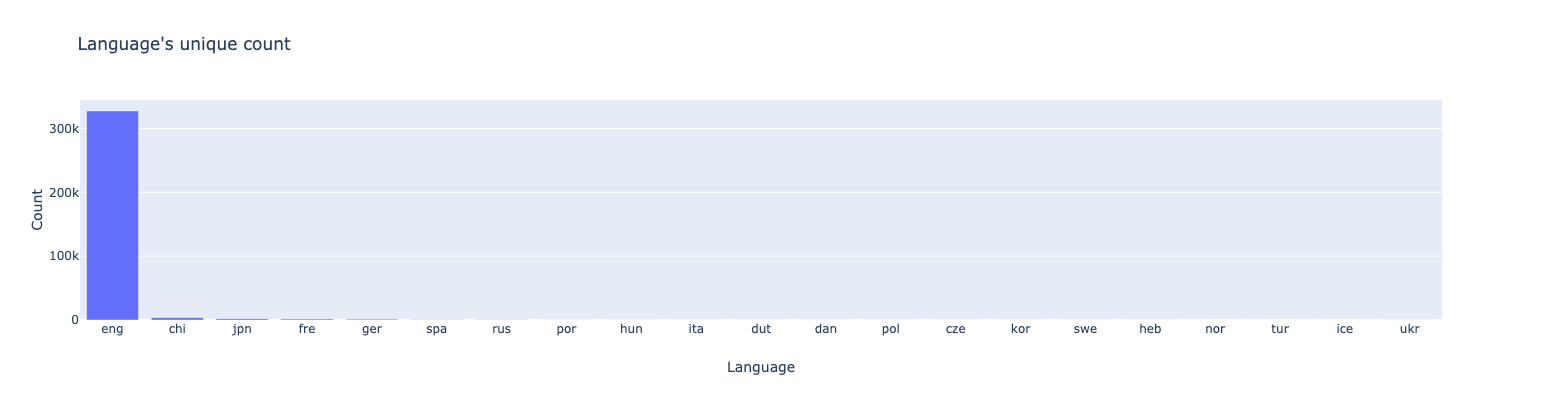

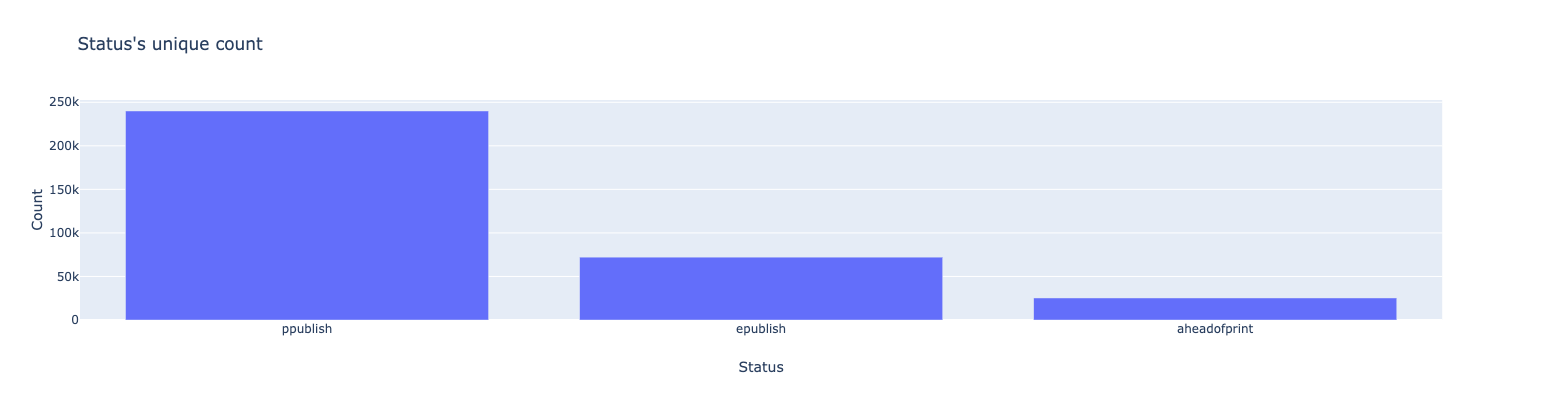

In [5]:
# Categorical Feature
for catCol in ['Language', 'Status']:
    fig = px.bar(df_article[catCol].value_counts().reset_index(), x='index', y=catCol, height=400, width=800, title="{}'s unique count".format(catCol), labels={catCol: 'Count', 'index': catCol})
    fig.show()

#### publish distribution

In [6]:
# concat
# df_article['ArticlePublishDate'] = df_article['Year_A'].fillna(0).astype(int).astype(str).str.zfill(4) + '-' +  df_article['Month_A'].fillna(0).astype(int).astype(str).str.zfill(2) + '-' +  df_article['Day_A'].fillna(0).astype(int).astype(str).str.zfill(2)
df_article['ArticlePublishDate'] = df_article['Year_A'].fillna(0).astype(int).astype(str).str.zfill(4) + '-' +  df_article['Month_A'].fillna(0).astype(int).astype(str).str.zfill(2)
df_article['PubMedPublishDate'] = df_article['Year_PM'].fillna(0).astype(int).astype(str).str.zfill(4) + '-' +  df_article['Month_PM'].fillna(0).astype(int).astype(str).str.zfill(2)


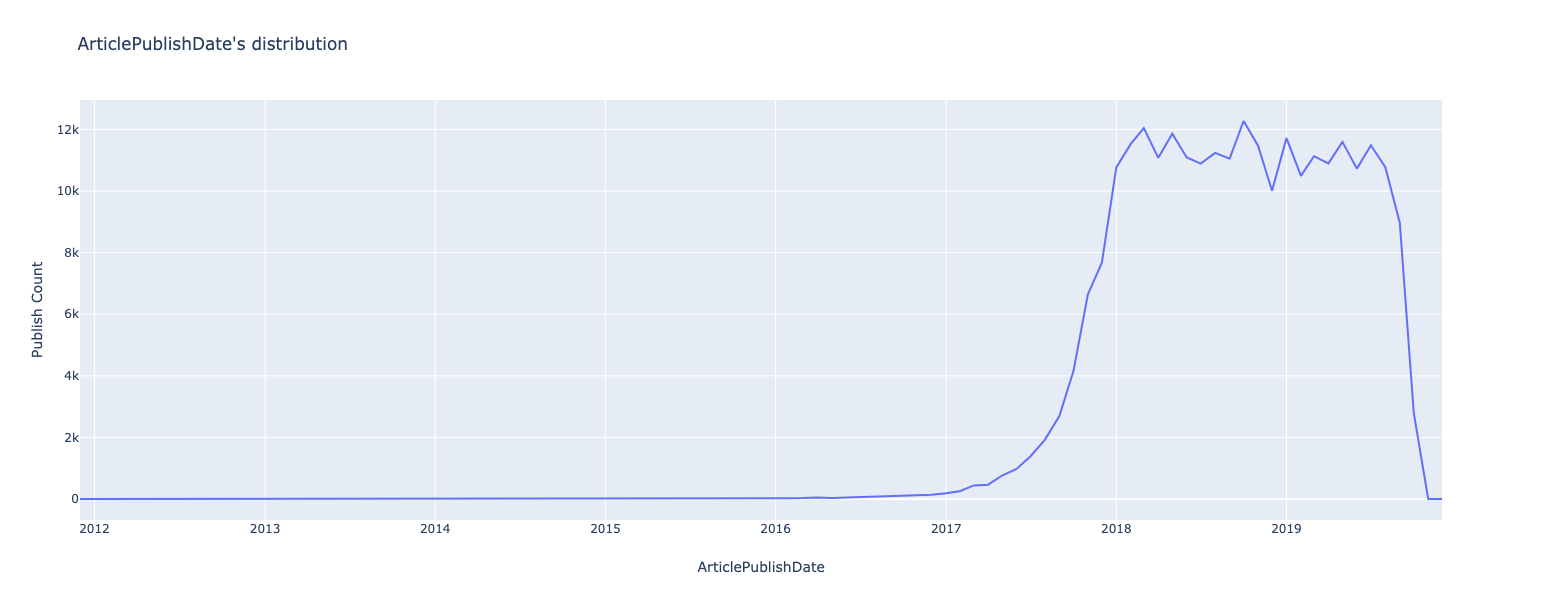

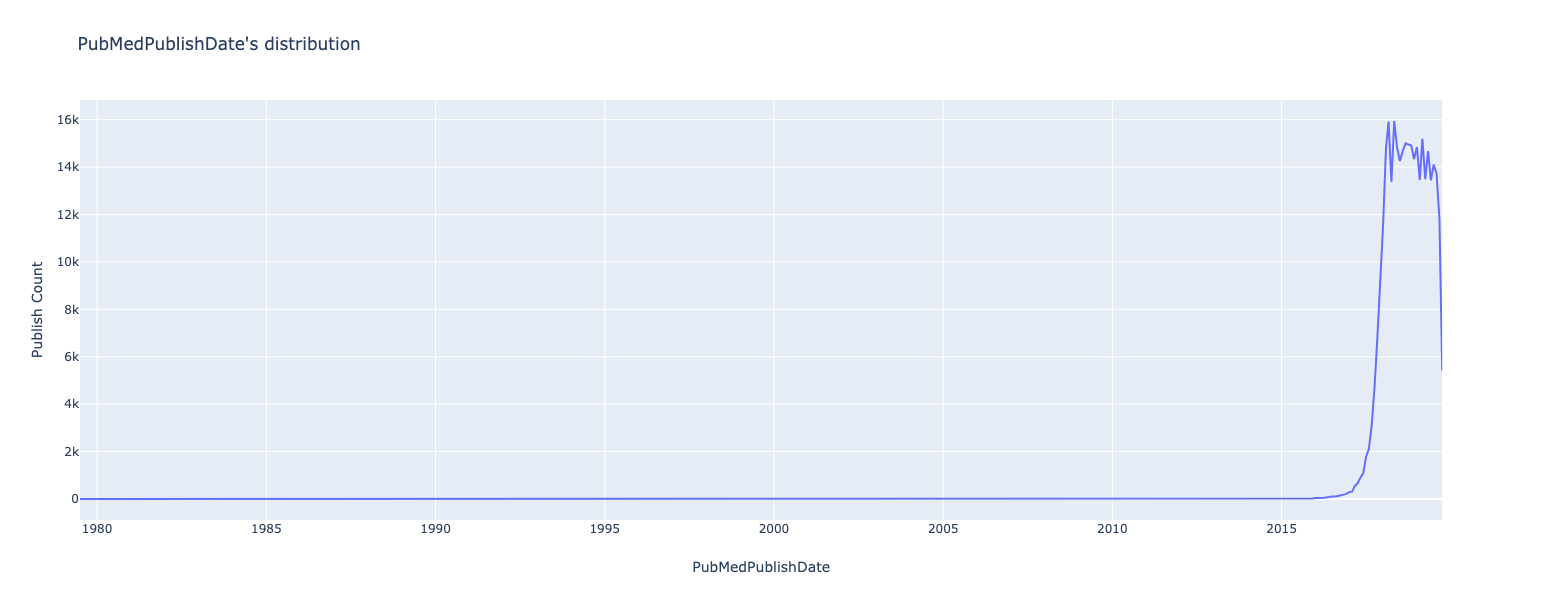

In [7]:
for catCol in ['ArticlePublishDate', 'PubMedPublishDate']:
    fig = px.line(df_article[df_article[catCol] != '0000-00'][catCol].value_counts().reset_index().sort_values('index'), x='index', y=catCol, height=600, width=1200, title="{}'s distribution".format(catCol), labels={catCol: 'Publish Count', 'index': catCol})
    fig.show()

#### what content 'not' english article includes?

In [8]:
df_article[df_article['Language'] != 'eng'].head(5)

PMID                                       JournalTitle  \
208  31604575                              Annales de pathologie   
209  31604570                                 Bulletin du cancer   
403  31602954  Zhongguo Zhong yao za zhi = Zhongguo zhongyao ...   
404  31602944  Zhongguo Zhong yao za zhi = Zhongguo zhongyao ...   
405  31602910  Zhongguo Zhong yao za zhi = Zhongguo zhongyao ...   

                                                 Title  \
208  [Guidelines for the macroscopic management of ...   
209  [Equal access to patient education in oncology...   
403  [Regulatory effects of glabridin and quercetin...   
404  [A landscape of transcriptome analysis of thre...   
405  [Pharmacodynamic effect and virulent effect of...   

                                    doi  \
208        10.1016/j.annpat.2019.05.008   
209        10.1016/j.bulcan.2019.08.015   
403  10.19540/j.cnki.cjcmm.20190505.401   
404  10.19540/j.cnki.cjcmm.20190701.112   
405  10.19540/j.cnki.cjcmm.20181119.001   

                                              Abstract Language  Year_A  \
208  Gross examination is an essential step for pat...      fre  2019.0   
209                                                NaN      fre  2019.0   
403  It is reported that energy metabolism is the c...      chi     NaN   
404  Polyporus umbellatus,a traditional Chinese pre...      chi     NaN   
405  To investigate the pharmacodynamic effect and ...      chi     NaN   

     Month_A  Day_A  Year_PM  Month_PM  Day_PM        Status MeSH MeSH_UI  \
208     10.0    8.0     2019        10      13  aheadofprint  NaN     NaN   
209     10.0    8.0     2019        10      13  aheadofprint  NaN     NaN   
403      NaN    NaN     2019        10      12      ppublish  NaN     NaN   
404      NaN    NaN     2019        10      12      ppublish  NaN     NaN   
405      NaN    NaN     2019        10      12      ppublish  NaN     NaN   

                                               Keyword ArticlePublishDate  \
208  Cancer pulmonaire|Guidelines|Lung cancer|Macro...            2019-10   
209  Cancer|Chronic disease|Health care inequalitie...            2019-10   
403  breast cancer cell|energy metabolism|glabridin...            0000-00   
404  effective content|growth|sclerotia of Polyporu...            0000-00   
405  ADME/T|Tripterygium wilfordii|network pharmaco...            0000-00   

    PubMedPublishDate  
208           2019-10  
209           2019-10  
403           2019-10  
404           2019-10  
405           2019-10

#### How many nan do articles include?
- PMID is require column.
- There are scarcely user identify ID(ORCID)

In [9]:
# False: not nan, True: is nan, values are percent
pd.merge(df_article, df_author, on='PMID', how='left').isnull().apply(lambda col: col.value_counts(), axis=0).fillna(0).astype(np.float).apply(lambda col: col/col.sum(), axis=0)

PMID  JournalTitle     Title       doi  Abstract  Language    Year_A  \
False   1.0           1.0  0.994961  0.977648  0.920882       1.0  0.818336   
True    0.0           0.0  0.005039  0.022352  0.079118       0.0  0.181664   

        Month_A     Day_A  Year_PM  ...  Status      MeSH   MeSH_UI   Keyword  \
False  0.818336  0.818336      1.0  ...     1.0  0.531469  0.531469  0.648765   
True   0.181664  0.181664      0.0  ...     0.0  0.468531  0.468531  0.351235   

       ArticlePublishDate  PubMedPublishDate  authorId      name  identifier  \
False                 1.0                1.0  0.999396  0.999396    0.074503   
True                  0.0                0.0  0.000604  0.000604    0.925497   

       identifierSource  
False          0.074503  
True           0.925497  

[2 rows x 22 columns]

#### How many authors in each articles?

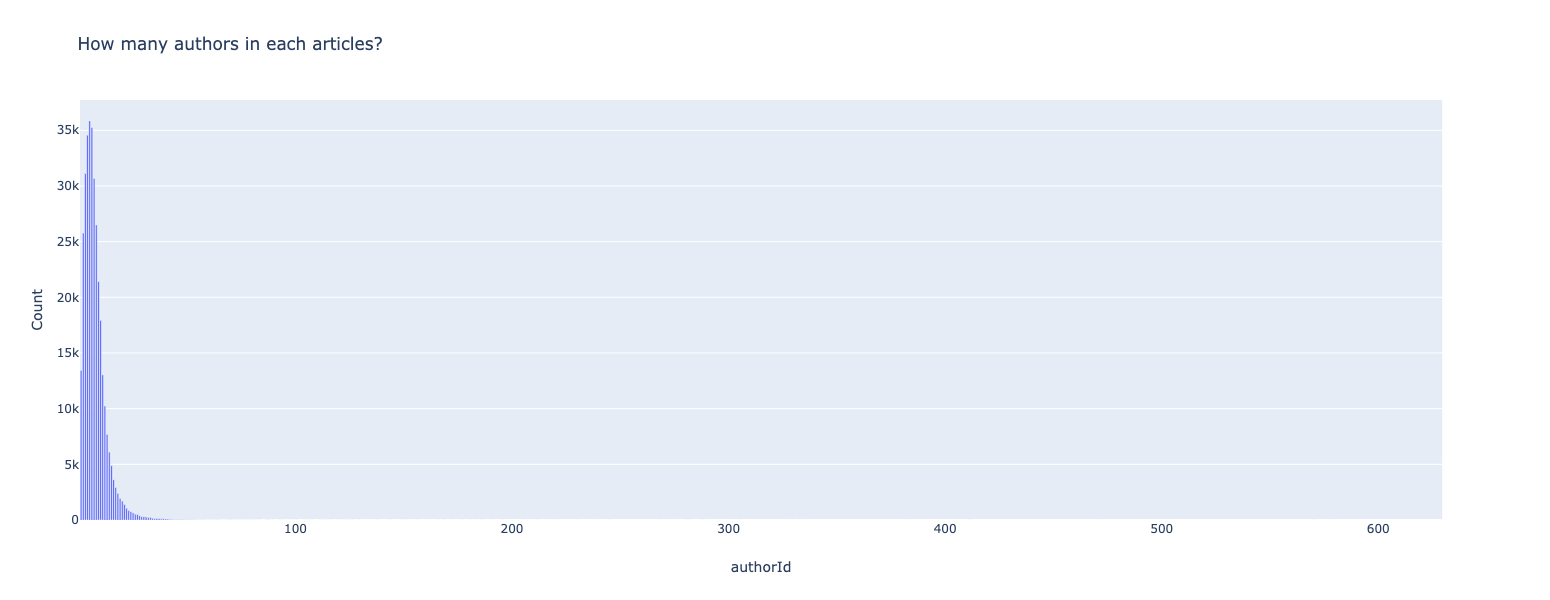

In [10]:
for catCol in ['authorId']:
    fig = px.bar(df_author.groupby('PMID', as_index=False).count()[catCol].value_counts().reset_index(), x='index', y=catCol, height=600, width=1600, title="How many authors in each articles?".format(catCol), labels={catCol: 'Count', 'index': catCol})
    fig.show()

#### Is MeSH or Keyword NaN?

In [11]:
# False: not nan, True: is nan, values are percent
pd.DataFrame(pd.DataFrame(df_article['MeSH'].fillna('').astype(str) + df_article['Keyword'].fillna('').astype(str))[0] == '').apply(lambda col: col.value_counts(), axis=0).fillna(0).astype(np.float).apply(lambda col: col/col.sum(), axis=0)

0
False  0.861903
True   0.138097

### Clustering

In [12]:
df_article['allText'] = df_article['Title'].fillna('') + df_article['Abstract'].fillna('') + df_article['MeSH'].fillna('') + df_article['Keyword'].fillna('')

In [13]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)

tfidf.fit(df_article.allText)
text = tfidf.fit_transform(df_article.allText)

Fit 10 clusters
Fit 20 clusters
Fit 30 clusters
Fit 40 clusters
Fit 50 clusters
Fit 60 clusters
Fit 70 clusters
Fit 80 clusters
Fit 90 clusters
Fit 100 clusters


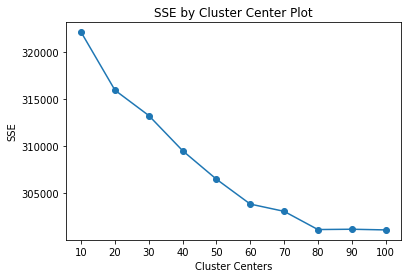

In [14]:
"""
Finding Optimal Clusters¶
https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
"""
def find_optimal_clusters(data, max_k):
    iters = range(10, max_k+1, 10)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 100)

In [15]:
# Clustring
clusters = MiniBatchKMeans(n_clusters=80, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

In [21]:
print(text.shape)
print(len(clusters))

(337416, 8000)
337416


In [65]:
# random sampling size
RANDOM_SAMPLING_SIZE = 3000

# random sampling
random_idx = np.random.choice(range(text.shape[0]), size=RANDOM_SAMPLING_SIZE, replace=False)

# t-sne(with random sampling pca)
tsne = TSNE(random_state=RANDOM_STATE).fit_transform(PCA(n_components=50, random_state=RANDOM_STATE).fit_transform(text[random_idx,:].todense()))

# random sampling df
df_article_tsne = df_article.iloc[random_idx]

# horizontal concat
df_article_tsne = df_article.iloc[random_idx].copy()
df_article_tsne['tsne_x'] = tsne[:, 0]
df_article_tsne['tsne_y'] = tsne[:, 1]
df_article_tsne['cluster'] = clusters[random_idx]
df_article_tsne.head()

PMID                              JournalTitle  \
32085   31354359            Cancer management and research   
116782  30690027                Experimental cell research   
35940   31323930                                  Vaccines   
253401  29673046  Diabetes/metabolism research and reviews   
32094   31354350            Cancer management and research   

                                                    Title  \
32085   Sinonasal/nasopharyngeal pleomorphic adenoma a...   
116782  Notch1 inhibition enhances DNA damage induced ...   
35940   From Vaccine Vector to Oncomodulation: Underst...   
253401  Newly diagnosed type 2 diabetes may serve as a...   
32094   Bioinformatics analysis of dysregulated microR...   

                                doi  \
32085          10.2147/CMAR.S198942   
116782  10.1016/j.yexcr.2019.01.014   
35940       10.3390/vaccines7030062   
253401            10.1002/dmrr.3018   
32094          10.2147/CMAR.S201335   

                                                 Abstract Language  Year_A  \
32085                                                 NaN      eng  2019.0   
116782  The expression of Notch1 plays an important ro...      eng  2019.0   
35940   Cytomegalovirus (CMV) is a herpesvirus that es...      eng  2019.0   
253401  Pancreatic cancer has an extremely highly case...      eng  2018.0   
32094                                                 NaN      eng  2019.0   

        Month_A  Day_A  Year_PM  ...    Status  \
32085       6.0   17.0     2019  ...  epublish   
116782      1.0   26.0     2019  ...  ppublish   
35940       7.0    9.0     2019  ...  epublish   
253401      6.0   17.0     2018  ...  ppublish   
32094       6.0   12.0     2019  ...  epublish   

                                                     MeSH  \
32085                                                 NaN   
116782                                                NaN   
35940                                                 NaN   
253401  Adult|Biomarkers, Tumor|Diabetes Mellitus, Typ...   
32094                                                 NaN   

                                                  MeSH_UI  \
32085                                                 NaN   
116782                                                NaN   
35940                                                 NaN   
253401  D000328|D014408|D003924|D018450|D055088|D00526...   
32094                                                 NaN   

                                                  Keyword ArticlePublishDate  \
32085   carcinoma ex- pleomorphic adenoma|endoscopic|n...            2019-06   
116782  ATM|Apoptosis|Cervical cancer|Cisplatin|DNA da...            2019-01   
35940   anti-tumor immunity|cancer vaccines|cytomegalo...            2019-07   
253401  early detection|newly diagnosed diabetes|pancr...            2018-06   
32094   breast cancer|chemoresistance|docetaxel|exosom...            2019-06   

       PubMedPublishDate                                            allText  \
32085            2019-07  Sinonasal/nasopharyngeal pleomorphic adenoma a...   
116782           2019-01  Notch1 inhibition enhances DNA damage induced ...   
35940            2019-07  From Vaccine Vector to Oncomodulation: Underst...   
253401           2018-04  Newly diagnosed type 2 diabetes may serve as a...   
32094            2019-07  Bioinformatics analysis of dysregulated microR...   

           tsne_x     tsne_y  cluster  
32085   -9.454226  26.023804       53  
116782 -48.622681  -6.096260       70  
35940   -3.073254  -9.257894       53  
253401  37.316956 -39.627686       67  
32094   50.381680   3.608618       10  

[5 rows x 22 columns]

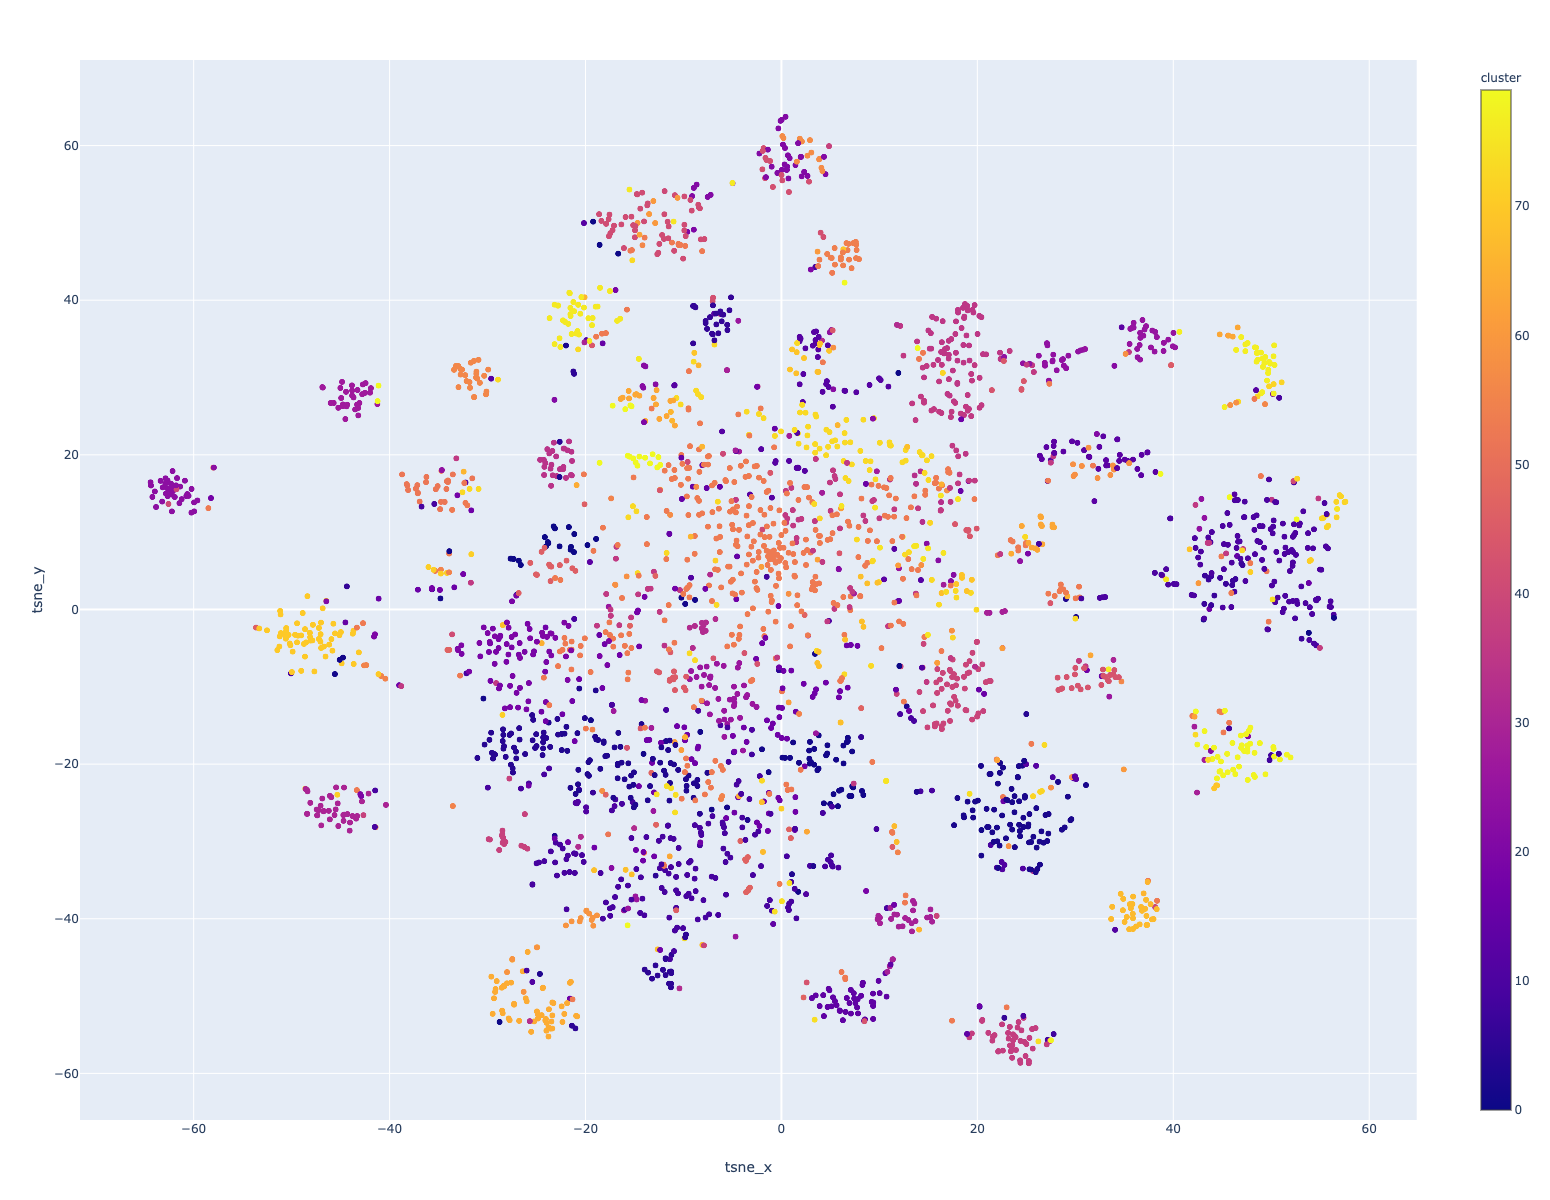

In [93]:
# scatter visualize
fig = px.scatter(
    df_article_tsne, 
    x="tsne_x", 
    y="tsne_y", 
    color="cluster",
    height=1200,
    # size='petal_length', 
    color_continuous_scale=px.colors.sequential.Plasma,
    hover_data=['Title', 'PMID']
)
fig.update_layout(
    showlegend=False
) 
fig.show()

In [97]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    clusterTexts = []
    
    for i,r in df.iterrows():
        top_keywords = ','.join([labels[t] for t in np.argsort(r)[-n_terms:]])
        clusterTexts.append(top_keywords)
#         print('\nCluster {}'.format(i))
#         print(top_keywords)
    return clusterTexts

clusterTexts = get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)

#### find seeds

In [120]:
df_article['cluster'] = clusters
df_cluster = pd.DataFrame(df_article.groupby('cluster', as_index=False).count().sort_values('cluster')['PMID'].values, columns=['num_articles'])
df_cluster['keywords'] = clusterTexts
df_cluster.sort_values('num_articles')

num_articles                                           keywords
48             1  cell,adhesion,metastatic,integrin,sponge,parag...
51             1  prospective,limb,shoulder,circumference,01,lym...
49             1  reaching,mtx,hd,progression,pcnsl,patients,yea...
31             2  persons,cancer,malignant,history,cancers,disea...
50            42  tumour,nanomedicine,regulates,reproducibility,...
65           530  cells,ferritin,cancer,nanoparticles,ferroptosi...
62           547  malignant,diagnosis,rare,case,tumors,ovarian,t...
60           896  apparent,adc,coefficient,dwi,mri,magnetic,reso...
59           915  therapy,adoptive,cd19,receptor,immunotherapy,c...
33           929  factors,heparin,cancer,anticoagulants,patients...
61           965  body,smooth,atrophy,cancer,wasting,mass,cachex...
40          1054  eus,cytology,endoscopic,fna,ultrasound,guided,...
8           1088  metastasis,tumor,cells,proliferation,cell,mir,...
42          1218  recurrence,robotic,assisted,cancer,rp,robot,pr...
28          1331  neoplasms,tumor,gi,tract,imatinib,gists,tumors...
55          1400  cell,acetylation,hdac,lysine,inhibitors,methyl...
71          1432  genes,variants,genetic,cancer,germline,breast,...
74          1452  tumor,proliferation,expression,cancer,cells,ce...
57          1460  therapy,adt,receptor,cancer,resistant,deprivat...
66          1482  net,aged,somatostatin,tumor,carcinoma,neoplasm...
7           1643  patients,growth,erbb,epidermal,cancer,receptor...
38          1783  proteins,mtor,protein,autophagic,induced,cance...
69          1876  advanced,response,locally,breast,cancer,chemor...
56          1890  aged,bone,sts,kaposi,synovial,sarcomas,ewing,t...
16          1904  cancer,snps,susceptibility,single,risk,associa...
47          1919  angiogenic,cell,tumor,cells,factor,growth,vegf...
32          2018  cells,dexamethasone,cell,bone,lenalidomide,pat...
18          2032  oncology,molecular,genomic,clinical,cancer,seq...
11          2033  growth,non,receptor,kinase,mutation,small,nscl...
68          2079  neoplasms,patients,stage,colorectal,tumor,cell...
..           ...                                                ...
23          3644  iodine,follicular,thyroidectomy,differentiated...
63          3726  tumor,mouth,aged,cancer,scc,oscc,cell,oral,car...
27          3760  tumor,aged,patients,cell,cutaneous,uveal,metas...
20          4087  cancer,tumor,cells,imaging,photodynamic,nps,go...
34          4114  rituximab,aged,follicular,patients,dlbcl,large...
30          4312  eoc,female,neoplasms,tumor,chemotherapy,cell,s...
78          4466  adenocarcinoma,aged,endoscopic,patients,helico...
13          4592  stereotactic,cancer,treatment,dose,planning,in...
67          4810  survival,patients,neoplasms,tumor,pancreas,ade...
41          4848  image,mr,aged,neoplasms,prostate,contrast,mri,...
70          4898  tumor,genome,cells,cancer,cell,replication,dam...
35          4937  services,oncology,quality,life,patients,patien...
4           5092  synthesis,molecular,drug,anticancer,agents,cel...
37          5232  microrna,micrornas,cells,cancer,proliferation,...
26          5302  inhibitors,microenvironment,immunity,cell,canc...
14          5363  survival,expression,tumor,hepatitis,patients,s...
19          5724  doxorubicin,systems,cells,dox,tumor,release,ca...
64          5759  cells,patients,lymphocytic,cell,chronic,lympho...
21          5889  biopsy,psa,castration,specific,men,antigen,pca...
39          6651  metastatic,risk,aged,expression,tumor,neoplasm...
12          7341  minimally,complications,procedures,postoperati...
1           7565  genome,rnas,regulation,cell,analysis,cancer,ge...
3           8226  cells,molecular,domain,signaling,inhibitors,ce...
2           9760  aged,carcinoma,adenocarcinoma,patients,nsclc,c...
73         11366  survival,factors,male,female,risk,middle,adult...
17         11692  cells,mitochondrial,oxidative,inflammatory,can...
10         12676  aged,mastectomy,negative,neoplasms,patient